In [24]:
# Import Libraries
import os
import gc
import shutil
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")

import xml.etree.ElementTree as xet


In [2]:
!git clone https://github.com/ultralytics/ultralytics


!pip install ultralytics
!pip install -U ray[tune]

Cloning into 'ultralytics'...
remote: Enumerating objects: 46188, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (280/280), done.
remote: Total 46188 (delta 220), reused 197 (delta 103), pack-reused 45805 (from 1)
Receiving objects: 100% (46188/46188), 38.34 MiB | 22.97 MiB/s, done.
Resolving deltas: 100% (34380/34380), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 13.7 MB/s eta 0:00:00


In [8]:

%%writefile /content/ultralytics/config.yaml

path: /content/dataset
train: images
val: images

nc: 1

names: [
    'license_plate'
]

Overwriting /content/ultralytics/config.yaml


In [9]:
# dataset
#   images
#     train
#     test
#     val
#   labels
#     train
#     test
#     val

In [81]:
!wandb disabled

# !yolo train model=yolov8n.pt data="/content/ultralytics/config.yaml" epochs=10 verbose=True batch=16

# !yolo task=detect mode=train model=yolov8n.pt data="/content/ultralytics/config.yaml" epochs=300 plots=True

!yolo task=detect mode=train model="/content/runs/detect/train7/weights/best.pt" data="/content/ultralytics/config.yaml" epochs=300 plots=True

W&B disabled.
Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train7/weights/best.pt, data=/content/ultralytics/config.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

In [18]:
!yolo task=detect mode=val model="/content/runs/detect/train4/weights/best.pt" data="/content/ultralytics/config.yaml"

Ultralytics 8.3.34 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/dataset/labels.cache... 268 images, 0 backgrounds, 0 corrupt: 100% 268/268 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 17/17 [00:04<00:00,  3.65it/s]
                   all        268        268      0.999      0.996      0.995      0.879
Speed: 0.9ms preprocess, 5.1ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [90]:
# # Get Bounding Box Predictions
from ultralytics import YOLO

path = "/content/dataset/images/Screenshot from 2024-11-19 18-27-47.png"

yolo_model = YOLO('/content/runs/detect/train7/weights/best.pt')
bbox_results = yolo_model.predict(path, verbose=False)




In [91]:
all_box_list = []
all_conf_list = []


for bbox_result in bbox_results:
    boxes = bbox_result.boxes
    box_list = []
    conf_list = []
    for box in boxes:
        box_data = box.data[0][:4]
        box_data = [int(x) for x in box_data]
        conf = round(float(box.conf), 2)
        if(conf>=0.5):
            box_list.append(box_data)
            conf_list.append(conf)

    all_box_list.append(box_list)
    all_conf_list.append(conf_list)

In [92]:
all_conf_list

[[0.94]]

In [93]:

# for i in bbox_results:
#   print(i.boxes)

print(all_box_list[0])
print(all_conf_list)


# for i, box in enumerate(boxes):
#   print(i, box)

[[111, 301, 234, 335]]
[[0.94]]


In [94]:
ori_path = path
print(ori_path)
ori_image = cv2.imread(ori_path)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

/content/dataset/images/Screenshot from 2024-11-19 18-27-47.png


In [95]:
from ultralytics.utils.plotting import Annotator


annotator = Annotator(ori_image)
boxes = all_box_list
confs = all_conf_list

In [96]:
for i in all_box_list[0]:
  print(i)

[111, 301, 234, 335]


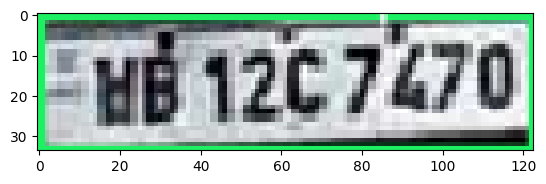

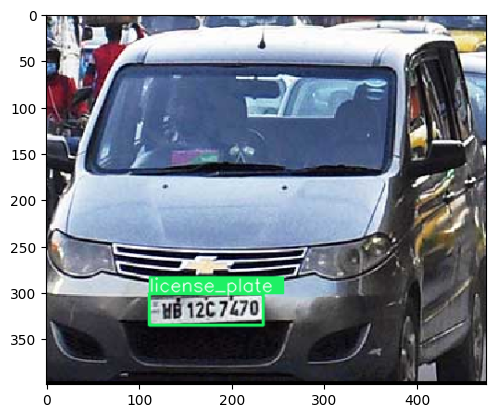

In [97]:
import matplotlib.pyplot as plt

# for i, box in enumerate(boxes):
#   print(i)
box = all_box_list[0][0]
confs = 0.120
annotator.box_label(box=box, label="license_plate ", color=(30, 240, 100))

# Get Plate Object
x1, y1, x2, y2 = box
x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
roi = ori_image[y1:y2, x1:x2]
plt.imshow(roi)
plt.show()

# Show Image
frame = annotator.result()
plt.imshow(frame)
plt.show()

In [ ]:
print(all_box_list)

[[[338, 315, 452, 345]]]


In [ ]:
all_conf_list

[[0.83]]